In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb, time

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Standardised Fama French 5 to industry portfolio 30
# Import data
data = pd.read_pickle("/Users/sikai/Downloads/ff5_30_standard_4000_draws.pkl")

In [3]:
# Restrict to 100 time points
X = data[10:410].transpose(2, 1, 0)
# X = data[100:].transpose(2, 1, 0)
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [4]:
n_dimensions, _, n_samples, time_steps = X_cov.shape
emp_inv = []
for i in range(time_steps):
    emp_inv.append(np.linalg.inv(np.mean(X_cov[:, :, :, i], 2)))
emp_inv = np.array(emp_inv)

In [5]:
from regain.covariance import GradientEqualTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl_g = GradientEqualTimeGraphicalLasso(max_iter=10, loss='LL', c_level=0.2, theta=0.5, rho=1e2, mult=1.1, weights=[None], m=50, eps=2, psi="laplacian")
emp_inv_score_g, baseline_score_g, fit_score_g, pre_g = tgl_g.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))

/Users/sikai/.pyenv/versions/3.7.6/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


0
-1.1960684985093541 -5.296470876822538
120096.7534558514


/Users/sikai/.pyenv/versions/3.7.6/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:2555: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/sikai/.pyenv/versions/3.7.6/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:2150: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/gradient_equal_time_graphical_lasso.py:242: RuntimeWarning: invalid value encountered in double_scalars
  return loss_res_t ** 2 + (loss_res_t - loss_res_pre_t - np.sum(nabla_t * (_Z_0_t - Z_0_t))) ** 2
/Users/sikai/.pyenv/versions/3.7.6/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:2148: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/sikai/Dropbox/Research/post_sum/code/re

9 29423874058.822304
inf inf
294779.0660693773 34.40062672940763
Running Time :114.68719952299999


In [6]:
# pre_g = np.load("grad_sol_ff5_ip30_10000_rho_1e2_mult_1.1_m_50_eps_2_lap.npy")
pre_g = np.load("/Users/sikai/Downloads/grad_long_ff5_ip30_10000_rho_1e2_mult_1.1_None_m_50_eps_2.npy")

In [7]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_g.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre_g_thres = {}
fit_score_g_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_g_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_g])
    tgl_g.precision_ = pre_g_thres[i]
    emp_inv_score, baseline_score, fit_score_g_thres[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre_g_thres[i], pre_g_thres[i][:-1], pre_g_thres[i][1:], psi, tgl_g.theta))

17705.761892142287
17705.772959114955
17705.77296399312


In [8]:
# pre_tpe = np.load("equal_sol_ff5_ip30_10000_rho_1e2_mult_1.1_m_50_eps_2_lap.npy")
pre_tpe = np.load("/Users/sikai/Downloads/lin_long_ff5_ip30_10000_rho_1e2_mult_1.1_None_m_50_eps_2.npy")

In [9]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_g.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre_tpe_thres = {}
fit_score_tpe_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_tpe_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_tpe])
    tgl_g.precision_ = pre_tpe_thres[i]
    emp_inv_score, baseline_score, fit_score_tpe_thres[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre_tpe_thres[i], pre_tpe_thres[i][:-1], pre_tpe_thres[i][1:], psi, tgl_g.theta))

17705.761892142287
17705.772959114955
17705.77296399312


In [ ]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
pre_cvx = np.load("mosek_sol_ff5_30_standard_alpha_0.2.npy")

In [ ]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_g.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
# for i in [1e-2, 1e-3, 1e-4, 1e-6]:
for i in [1e-4]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl_g.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][1:], psi, tgl_g.theta))

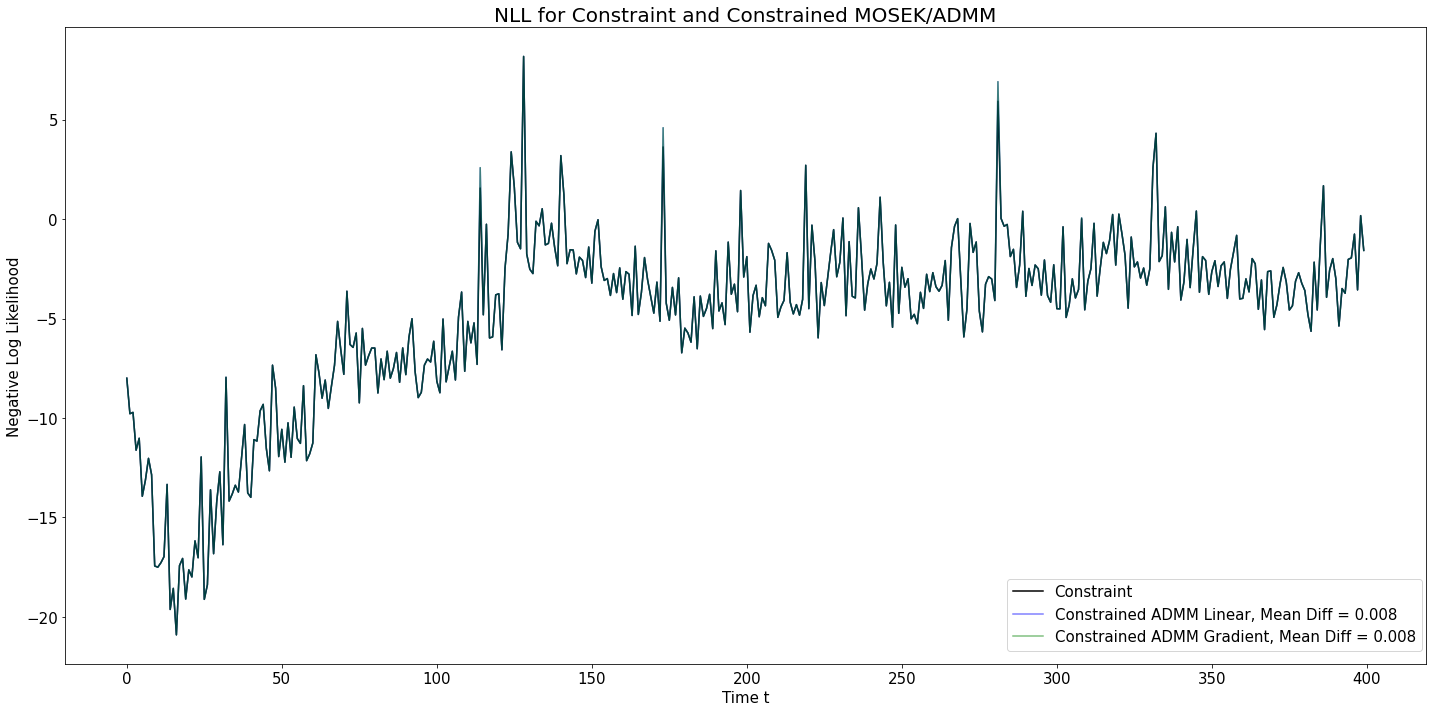

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

# ax.plot(range(X_cov.shape[-1]), emp_inv_score_g, color='y', label=r'Empirical Inverse')
ax.plot(range(X_cov.shape[-1]), baseline_score_g, color='k', label=r'Constraint')
# for i in [1e-4]:
#     mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
#     ax.plot(range(X_cov.shape[-1]), fit_score[i], color='r', alpha=0.5, 
# #     ax.plot(range(X_cov.shape[-1]), fit_score[i], color=colors[color_index], alpha=0.5, 
#             label=r'Constrained MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
#     color_index += 1
# mean_diff = np.mean(np.array(fit_score_tp_thres[1e-4]) - baseline_score_g)
# # ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
# ax.plot(range(X_cov.shape[-1]), fit_score_tp_thres[1e-4], alpha=0.5, color='m',
#         label=r'Constrained ADMM Full, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_tpe_thres[1e-4]) - baseline_score_g)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_tpe_thres[1e-4], alpha=0.5, color='b',
        label=r'Constrained ADMM Linear, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_g_thres[1e-4]) - baseline_score_g)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_g_thres[1e-4], alpha=0.5, color='g',
        label=r'Constrained ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_) - baseline_score_g)
# ax.plot(range(X_cov.shape[-1]), fit_score_, color='y', label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(mean_diff))

fig.legend(fontsize=15, loc='lower right', bbox_to_anchor=(0.495, 0.08, 0.5, 0.5))
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'NLL for Constraint and Constrained MOSEK/ADMM', fontsize=20)
plt.tight_layout()
# plt.savefig('ff5_ip30_10000_lin_diff_like_indiv.pdf')

In [13]:
import networkx as nx
labels_ = ['Food','Beer','Smoke','Games','Books','Hshld','Clths','Hlth','Chems','Txtls','Cnstr','Steel','FabPr','ElcEq','Autos','Carry','Mines','Coal','Oil','Util','Telcm','Servs','BusEq','Paper','Trans','Whlsl','Rtail','Meals','Fin','Other']
labels = {}
for i in range(len(labels_)):
    labels[i] = labels_[i]

In [14]:
labels

{0: 'Food',
 1: 'Beer',
 2: 'Smoke',
 3: 'Games',
 4: 'Books',
 5: 'Hshld',
 6: 'Clths',
 7: 'Hlth',
 8: 'Chems',
 9: 'Txtls',
 10: 'Cnstr',
 11: 'Steel',
 12: 'FabPr',
 13: 'ElcEq',
 14: 'Autos',
 15: 'Carry',
 16: 'Mines',
 17: 'Coal',
 18: 'Oil',
 19: 'Util',
 20: 'Telcm',
 21: 'Servs',
 22: 'BusEq',
 23: 'Paper',
 24: 'Trans',
 25: 'Whlsl',
 26: 'Rtail',
 27: 'Meals',
 28: 'Fin',
 29: 'Other'}

In [15]:
def circular_layout(G, index, scale=0.1, center=None, dim=2):
    # dim=2 only
    """Position nodes on a circle.

    Parameters
    ----------
    G : NetworkX graph or list of nodes
        A position will be assigned to every node in G.

    scale : number (default: 1)
        Scale factor for positions.

    center : array-like or None
        Coordinate pair around which to center the layout.

    dim : int
        Dimension of layout.
        If dim>2, the remaining dimensions are set to zero
        in the returned positions.
        If dim<2, a ValueError is raised.

    Returns
    -------
    pos : dict
        A dictionary of positions keyed by node

    Raises
    -------
    ValueError
        If dim < 2

    Examples
    --------
    >>> G = nx.path_graph(4)
    >>> pos = nx.circular_layout(G)

    Notes
    -----
    This algorithm currently only works in two dimensions and does not
    try to minimize edge crossings.

    """
    import numpy as np

    if dim < 2:
        raise ValueError("cannot handle dimensions < 2")

    # Discard the extra angle since it matches 0 radians.
    theta = np.linspace(0, 1, len(G))[:-1] * 2 * np.pi
    theta = theta.astype(np.float32)
    pos = np.column_stack(
            [np.cos(theta), np.sin(theta)]
        )
    pos = nx.rescale_layout(pos, scale=scale)
    centre = [0, pos[0][1]]
#     pdb.set_trace()
#     pos = np.vstack((centre, pos))
    pos = np.insert(pos, index, centre, 0) 
    pos = dict(zip(G, pos))

    return pos

In [16]:
def yearly_probabilities(precisions, div, thres, index, labels):
    import math
     
    time_points, _, _ = precisions.shape
    n_years = np.floor(time_points / div).astype(int)
    
    probs = {}
    
    for i in range(n_years):
        for j in range(div):
            try:
                probs[i] += (abs(precisions[(i * div) + j][index]) > 0).astype(int)
            except KeyError:
                probs[i] = (abs(precisions[(i * div) + j][index]) > 0).astype(int)
        probs[i] = (probs[i] / div) * (probs[i] / div > thres) 
        
    fig, axes = plt.subplots(nrows=4, ncols=math.ceil(len(probs.keys()) / 4), figsize=(12 * math.ceil(len(probs.keys()) / 4), 12 * 4))
    fig.suptitle('Yearly Edge Probabilities for {}'.format(labels[index].title()), fontsize=40)
    
    for i in probs.keys():
        probs_i_ = np.array(np.delete(probs[i], index))
        rows = np.delete(np.arange(len(labels)), index)
        cols = [index] * (len(rows))
        edges = [e for e in zip(cols, rows.tolist(), probs_i_)]
        edges = [e for e in edges if (e[2] > 0)]
        probs_i = np.array([p for p in probs_i_ if p > 0])
        gr = nx.Graph()
        gr.add_nodes_from(range(len(labels)))
        gr.add_weighted_edges_from(edges)
        pos = circular_layout(gr, index)
        nx.draw_networkx_nodes(gr, pos, ax=axes.flat[i], node_size=4000)
        edges = nx.draw_networkx_edges(gr, pos, ax=axes.flat[i], width=10*probs_i, edge_cmap=plt.cm.YlOrRd, edge_color=probs_i)
        nx.draw_networkx_labels(gr, pos, ax=axes.flat[i], labels=labels, font_size=20, font_color='white')
        axes.flat[i].set_title('{} - {}'.format(1965 + 2 * i, 1965 + 2 * i + 1), fontsize=30)
        
    plt.tight_layout()
    fig.subplots_adjust(top=0.95, right=0.95)
    cbar_ax = fig.add_axes([0.975, 0.05, 0.015, 0.9])
    cbar = fig.colorbar(edges, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=30)
    
    plt.savefig('plots/yp_{}.pdf'.format(labels[index].lower()))

In [1]:
def yearly_diff_probabilities(precisions, div, thres, index, labels):
    import math
     
    time_points, _, _ = precisions.shape
    n_years = np.floor(time_points / div).astype(int)

    probs = {}
    
    for i in range(n_years):
        for j in range(div):
            try:
                probs[i] += (abs(precisions[(i * div) + j][index]) > 0).astype(int)
            except KeyError:
                probs[i] = (abs(precisions[(i * div) + j][index]) > 0).astype(int)
        probs[i] = probs[i] / div
        
    probs_diff = {}

    for i in range(1, n_years):
        probs_diff[i] = (probs[i] - probs[i-1]) * (abs(probs[i] - probs[i-1]) > thres)     
    
    fig, axes = plt.subplots(nrows=2, ncols=math.ceil(len(probs.keys()) / 2), figsize=(12 * math.ceil(len(probs.keys()) / 2), 12 * 2 ))
    fig.suptitle('Yearly Edge Probabilities for {}'.format(labels[index].title()), fontsize=40)
    
    for i in probs_diff.keys():
        probs_i_ = np.array(np.delete(probs_diff[i], index))
        rows = np.delete(np.arange(len(labels)), index)
        cols = [index] * (len(rows))
        edges = [e for e in zip(cols, rows.tolist(), probs_i_)]
        edges = [e for e in edges if (e[2] != 0)]
        probs_i = np.array([p for p in probs_i_ if p != 0])
        gr = nx.Graph()
        gr.add_nodes_from(range(len(labels)))
        gr.add_weighted_edges_from(edges)
        pos = circular_layout(gr, index)
        nx.draw_networkx_nodes(gr, pos, ax=axes.flat[i], node_size=4000)
        axes.flat[i].set_position([0, 0, 1, 1])
        edges = nx.draw_networkx_edges(gr, pos, ax=axes.flat[i], width=10*probs_i, edge_cmap=plt.cm.YlOrRd, edge_color=probs_i)
        nx.draw_networkx_labels(gr, pos, ax=axes.flat[i], labels=labels, font_size=20, font_color='white')

    fig.subplots_adjust(top=0.95, right=0.95)
    cbar_ax = fig.add_axes([0.975, 0.05, 0.015, 0.9])
    cbar = fig.colorbar(edges, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=30)
    plt.tight_layout()
    
    plt.savefig('plots/ydp_{}.pdf'.format(labels[index].lower()))    

In [18]:
def degree(precisions, index, labels):
    import math
    from scipy.interpolate import Rbf
    
    time_points, _, _ = precisions.shape
    
    degrees = []
    
    for i in range(time_points):
        degrees.append(sum(precisions[i][index] != 0))
        
    plt.figure(figsize=(10, 8))
    rbf = Rbf(range(time_points), degrees)
    plt.plot(range(time_points), rbf(range(time_points)))
#     plt.plot(range(time_points), degrees)
    
    plt.ylabel('Degree')
    plt.xlabel('Time Points')
#     y_int = range(min(degrees), math.ceil(max(degrees))+1)
#     plt.yticks(y_int)
    plt.title('Degree over Time for {}'.format(labels[index].title()))
    plt.tight_layout()

    plt.savefig('plots/deg_{}.pdf'.format(labels[index].lower()))  

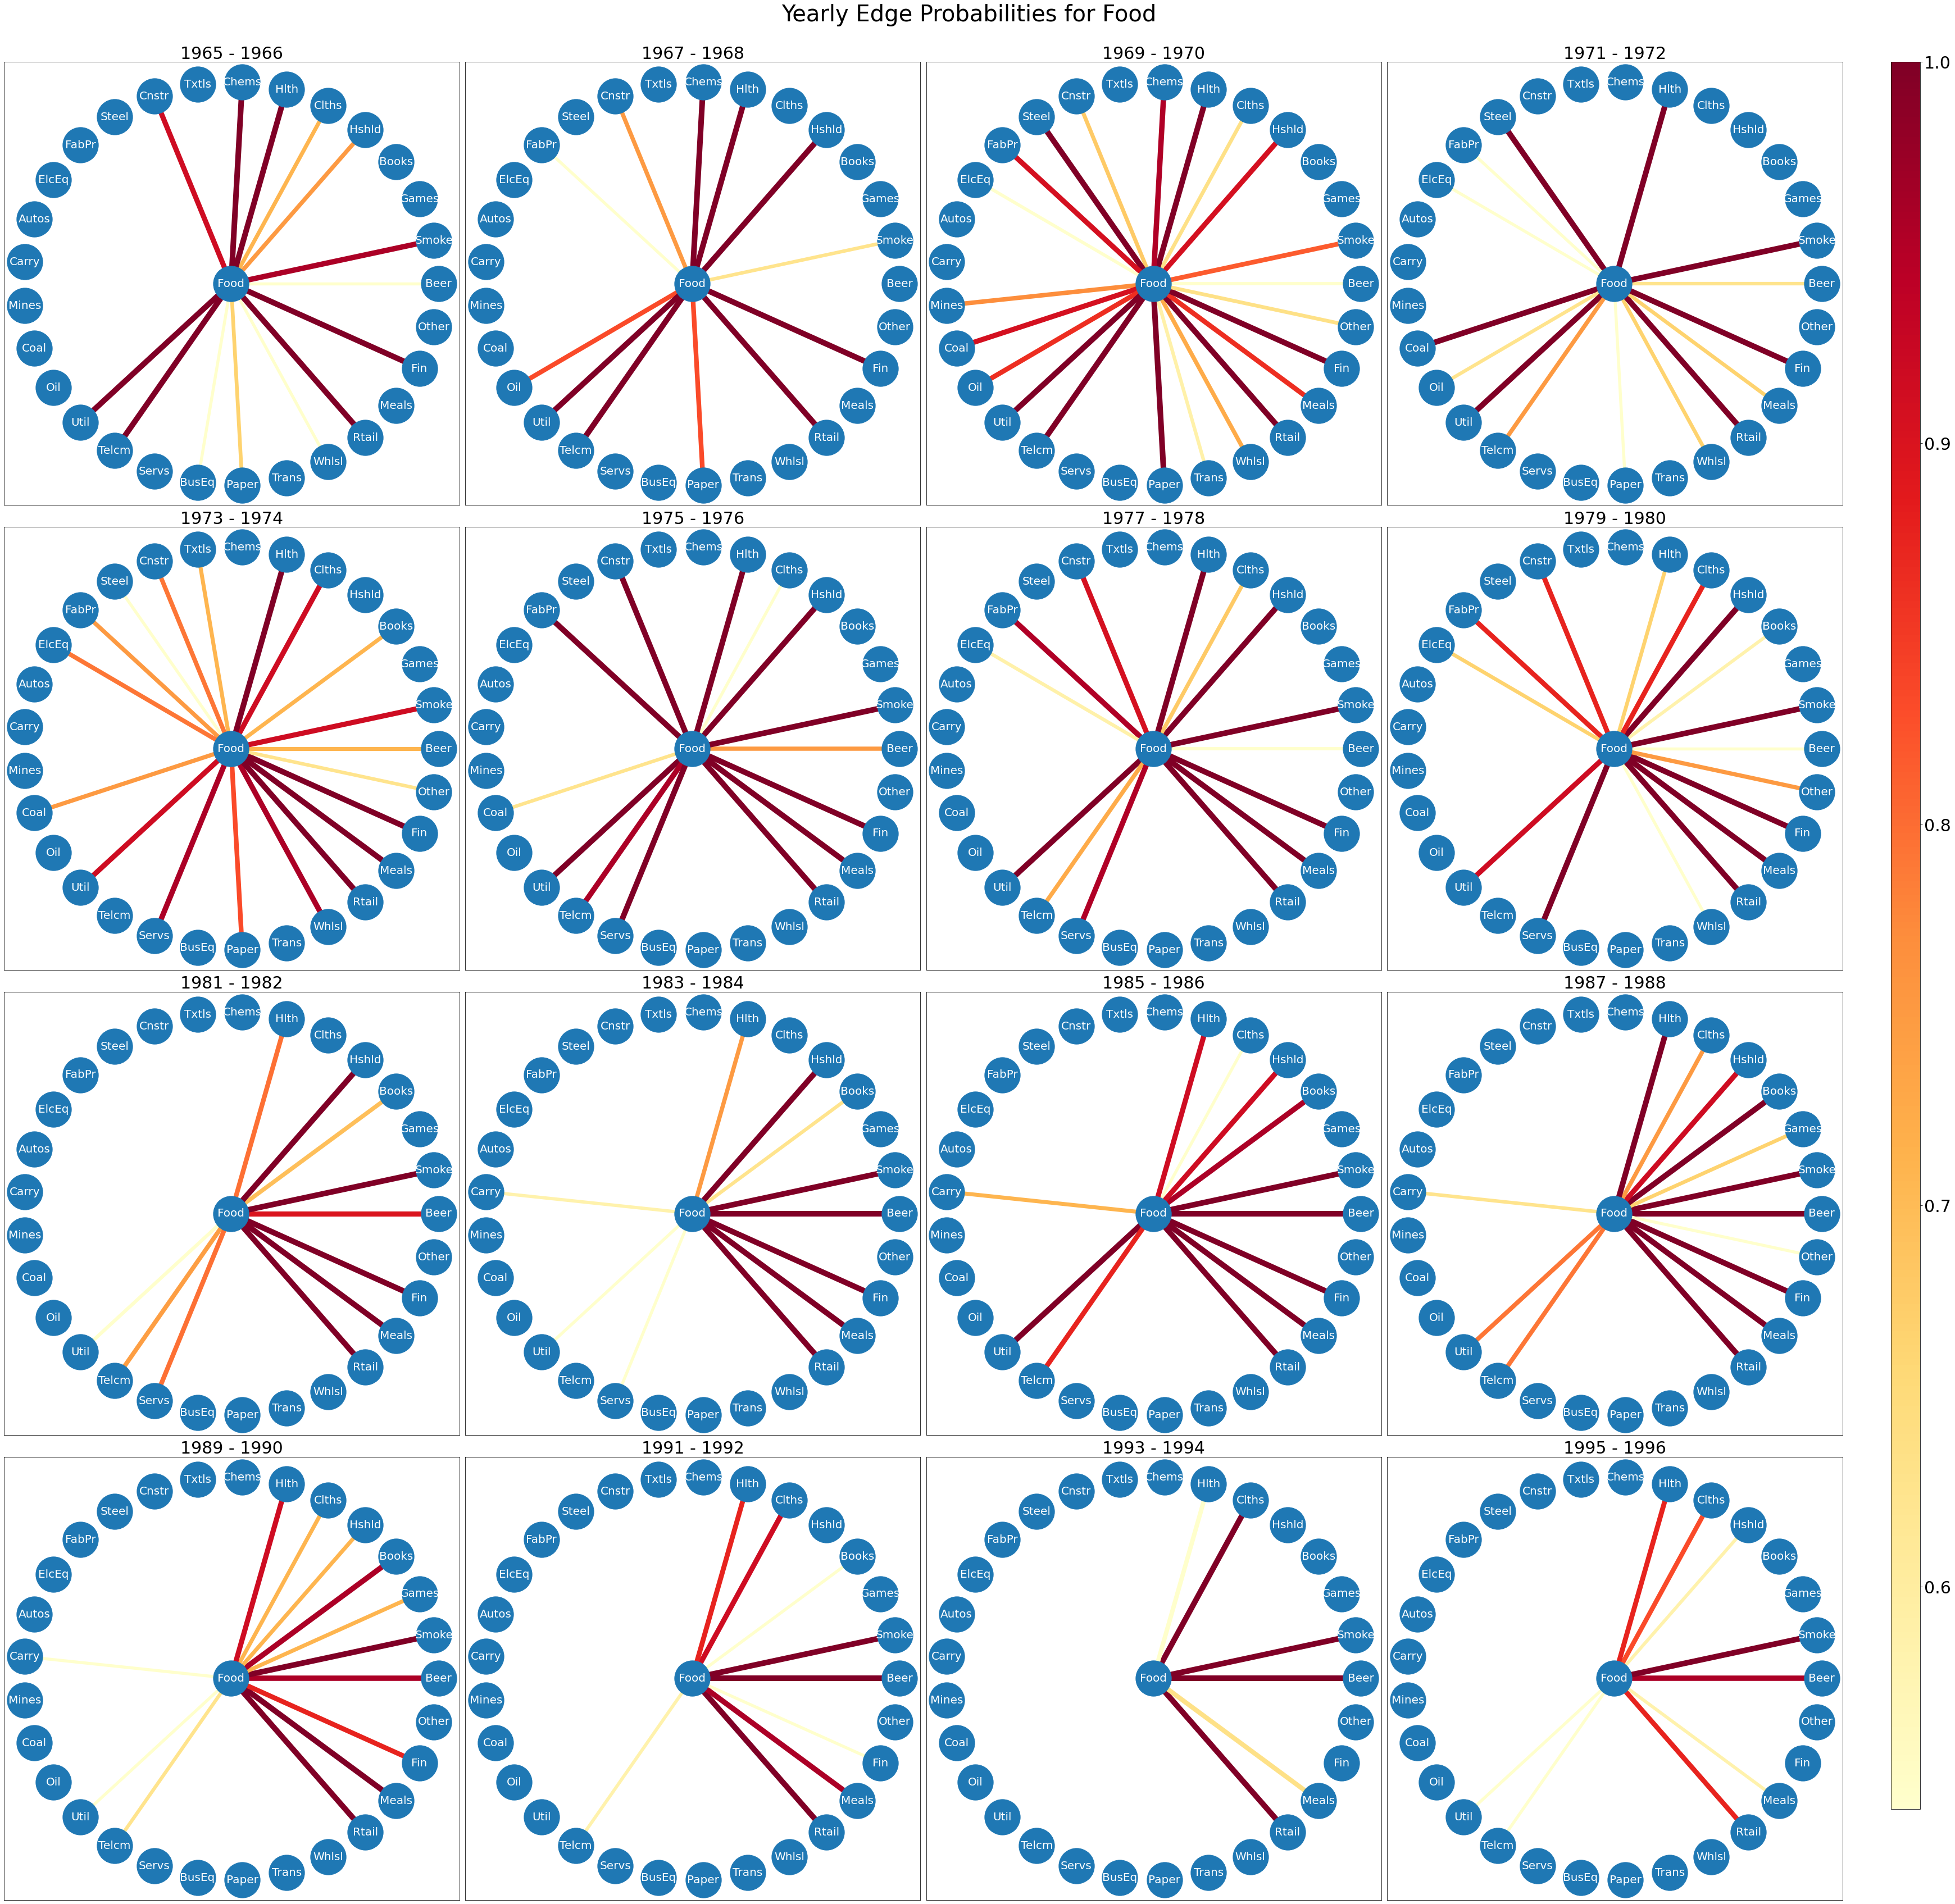

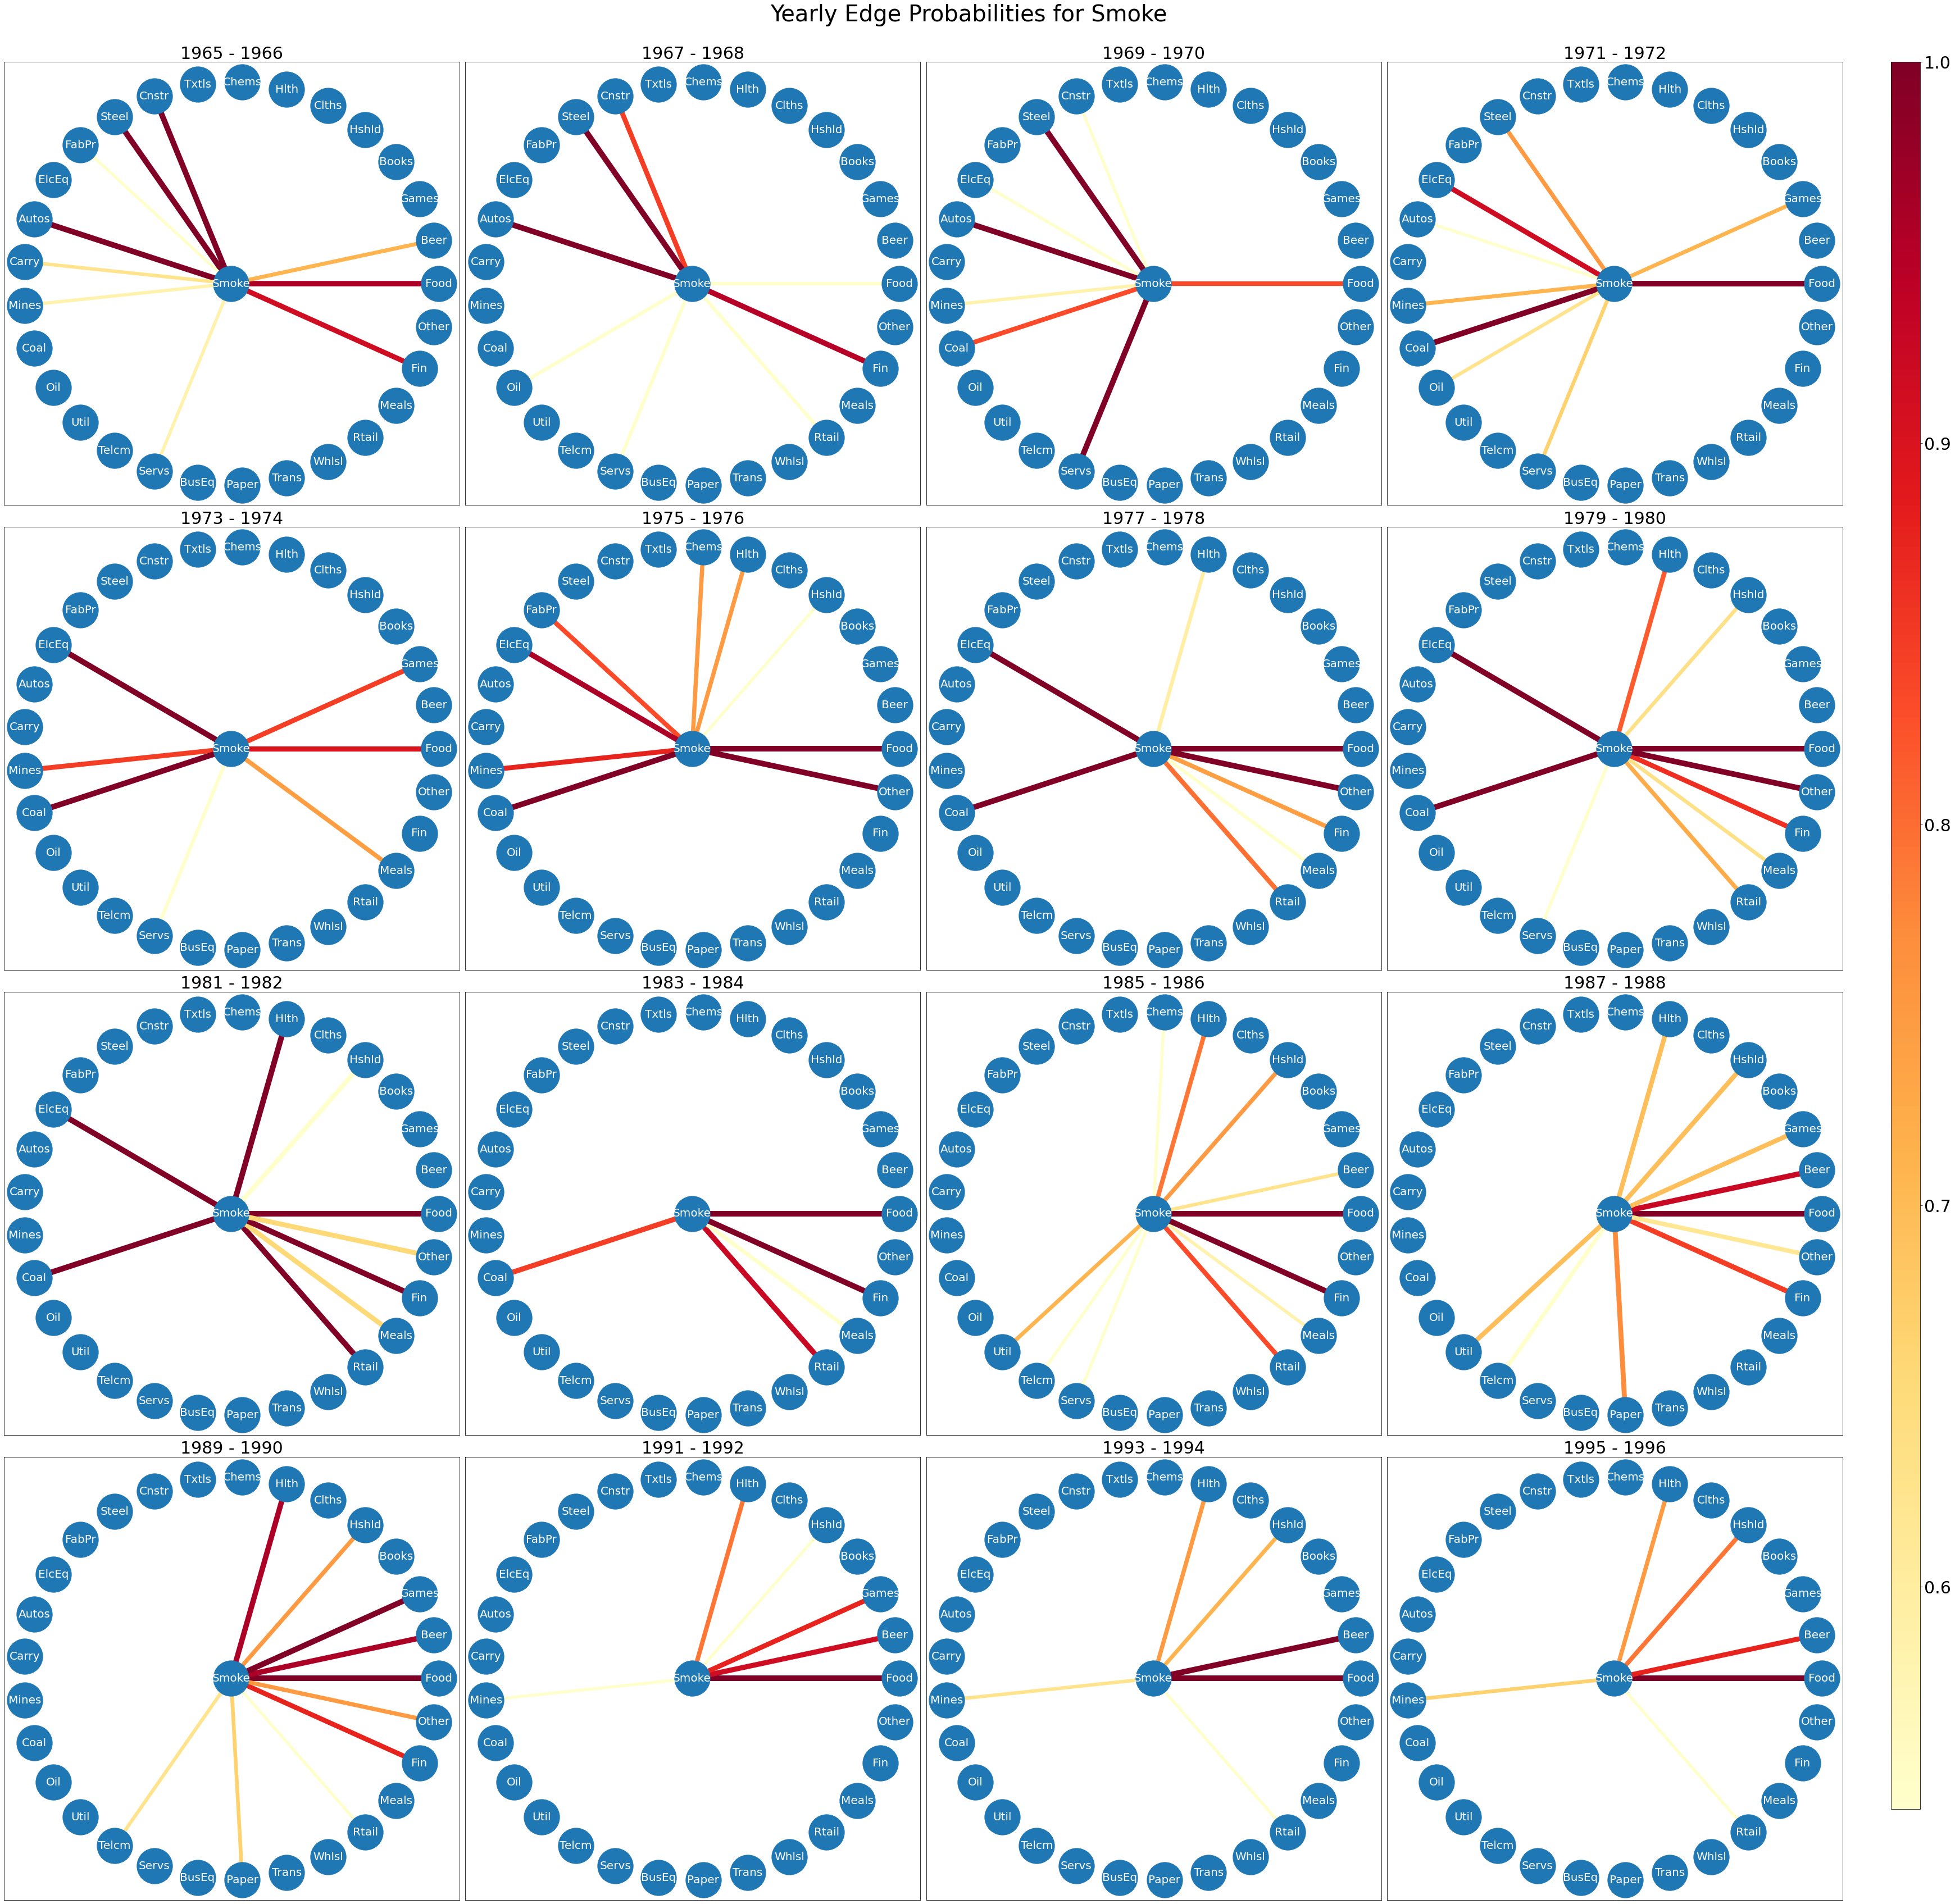

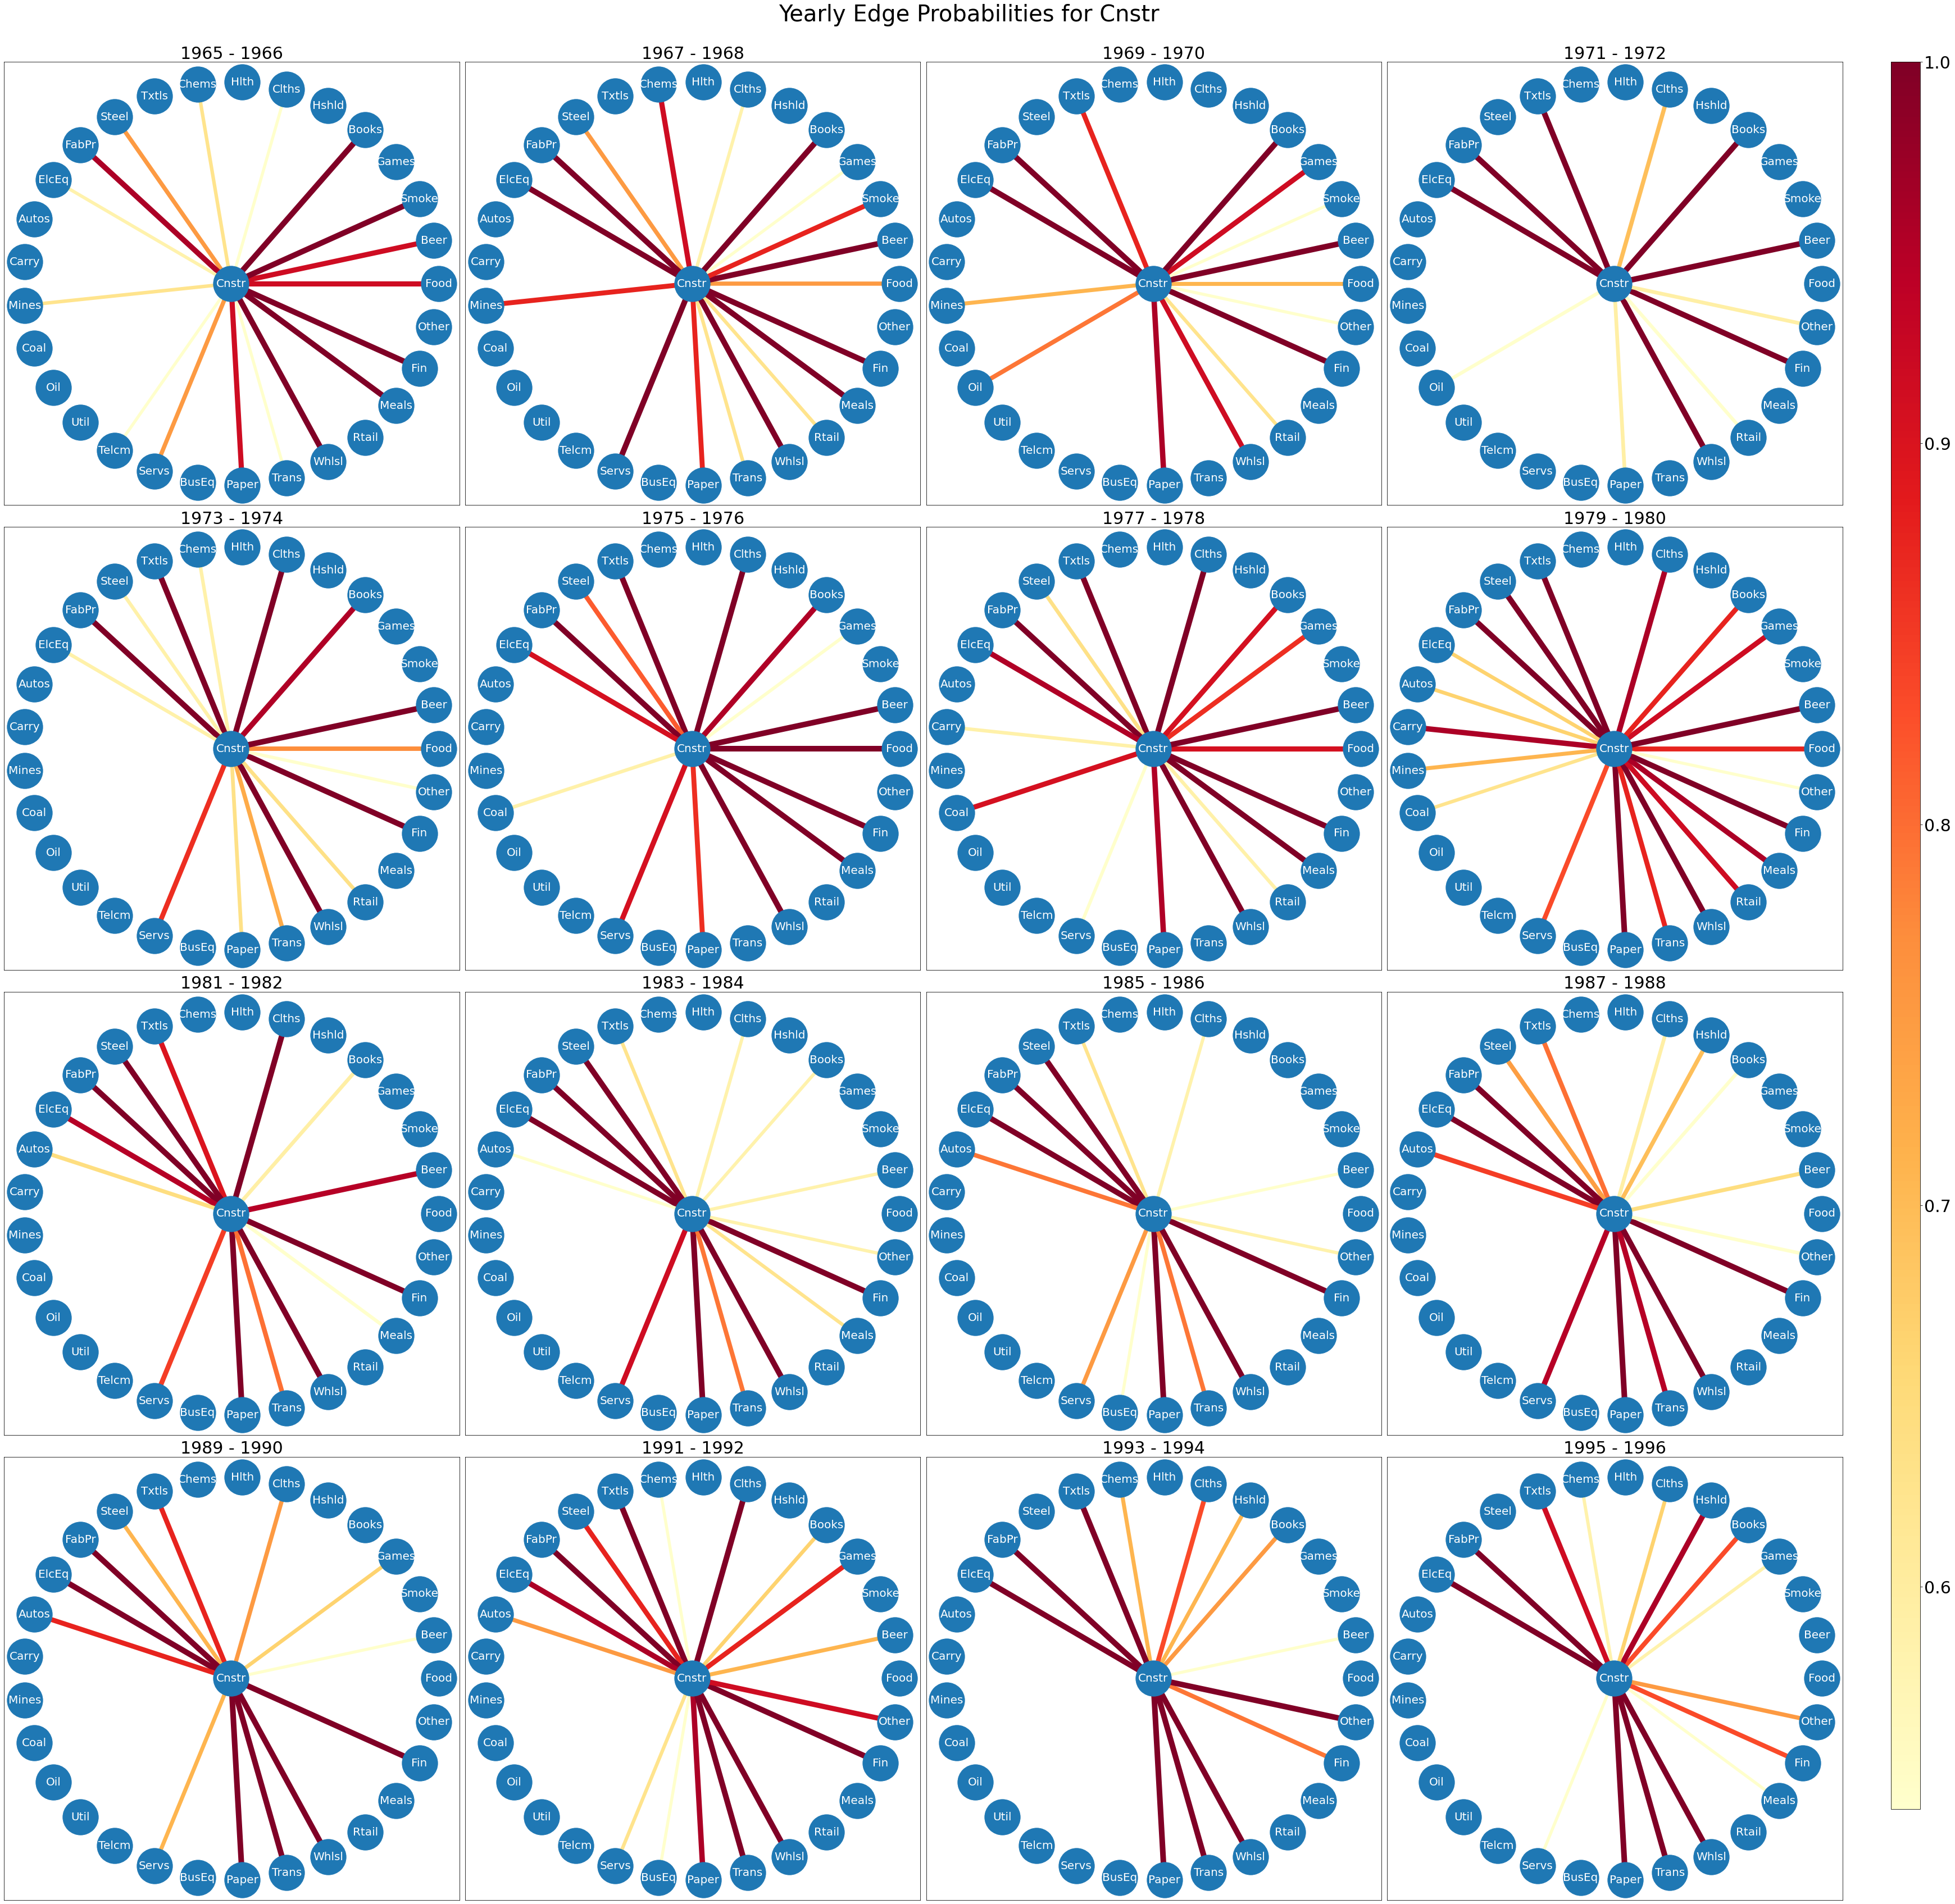

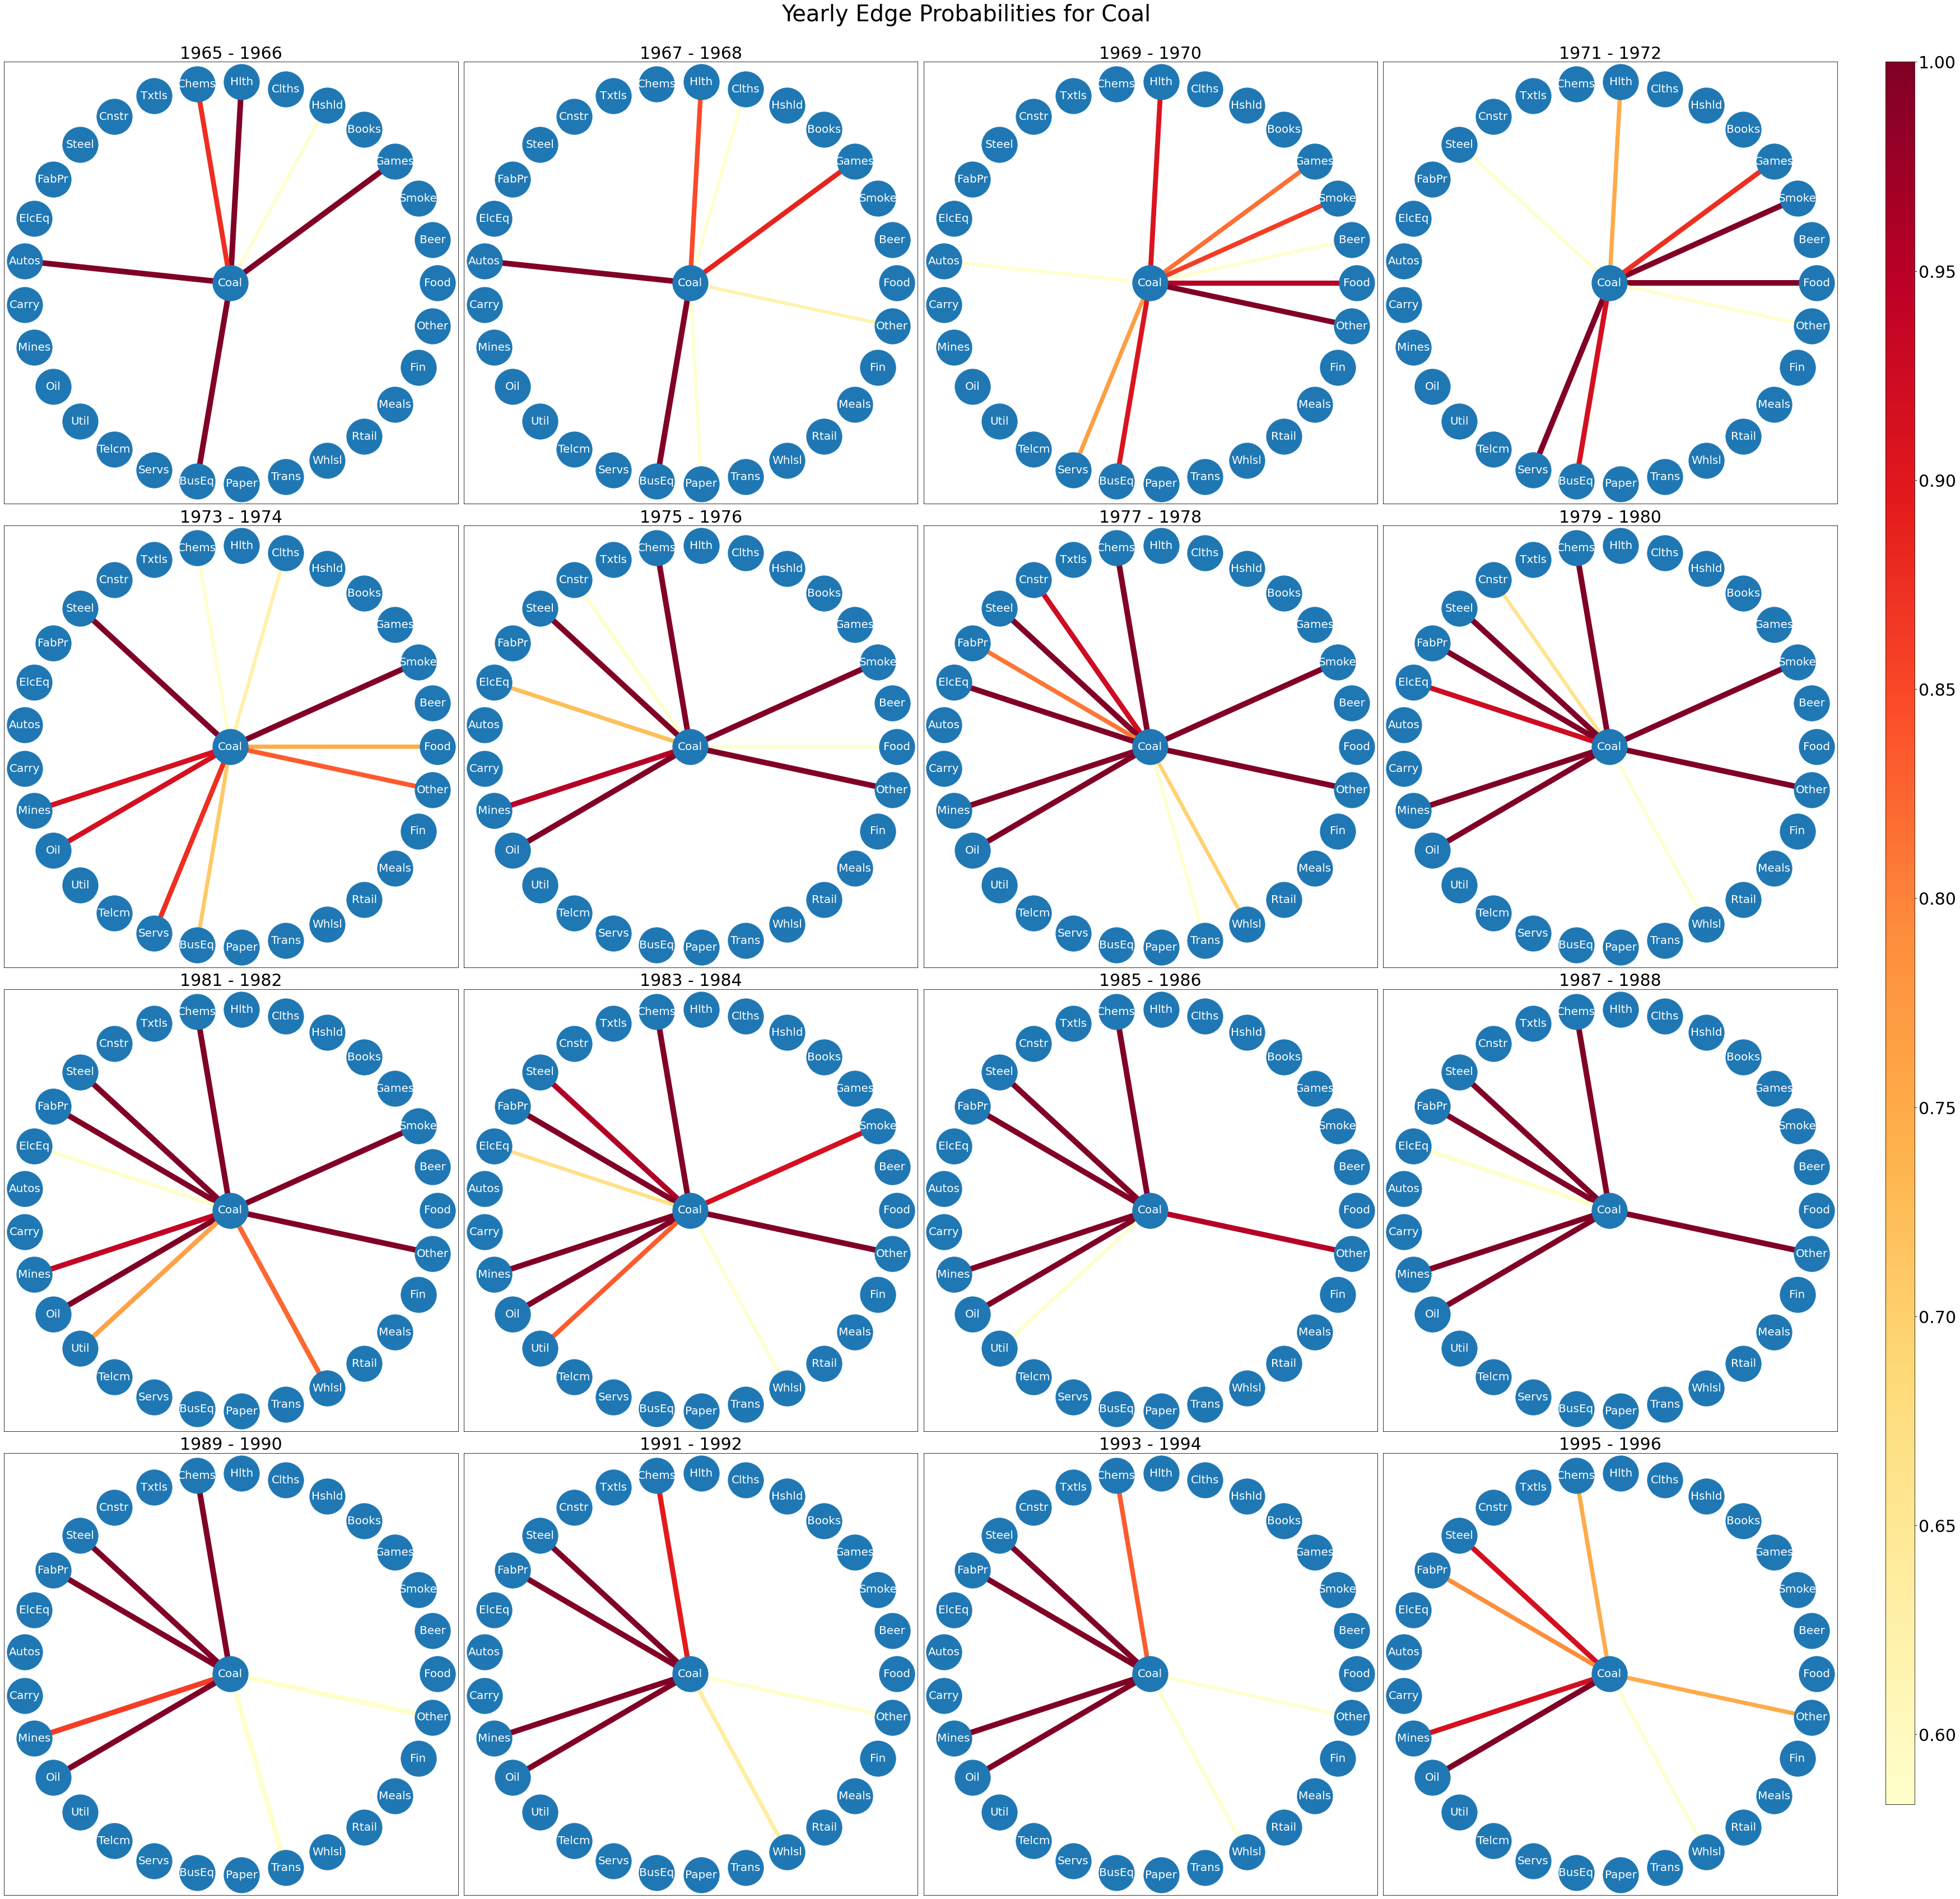

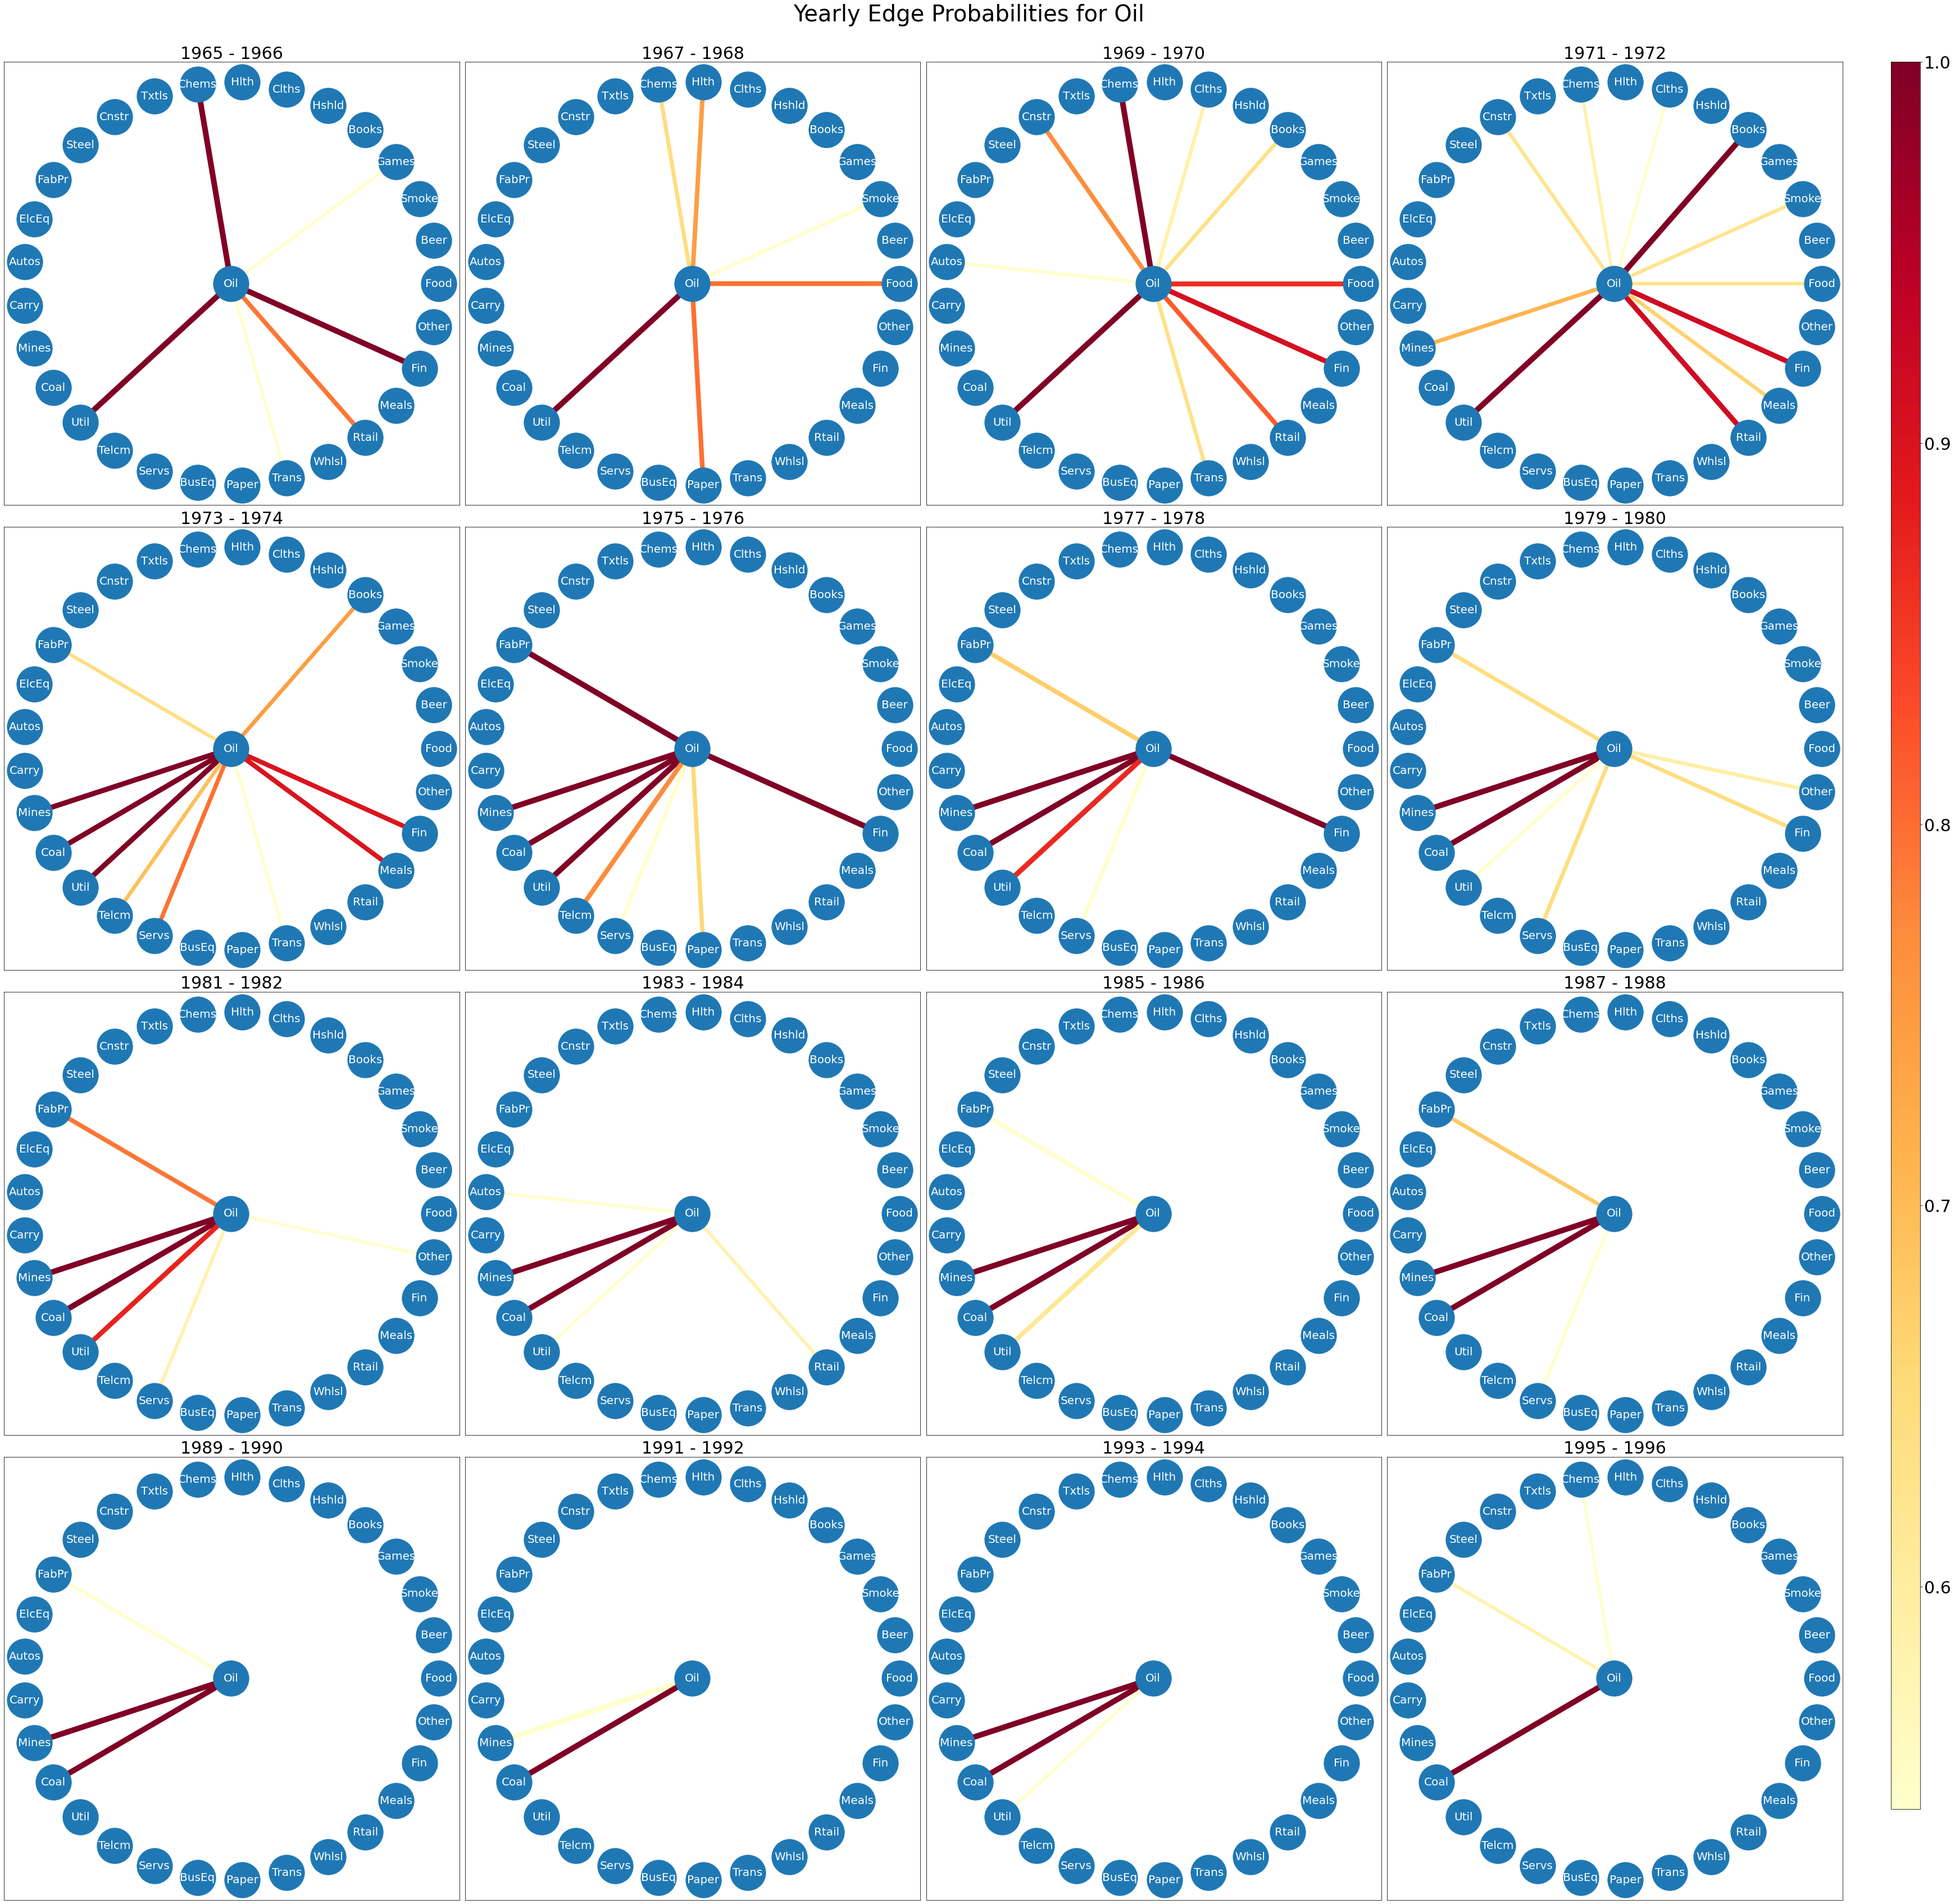

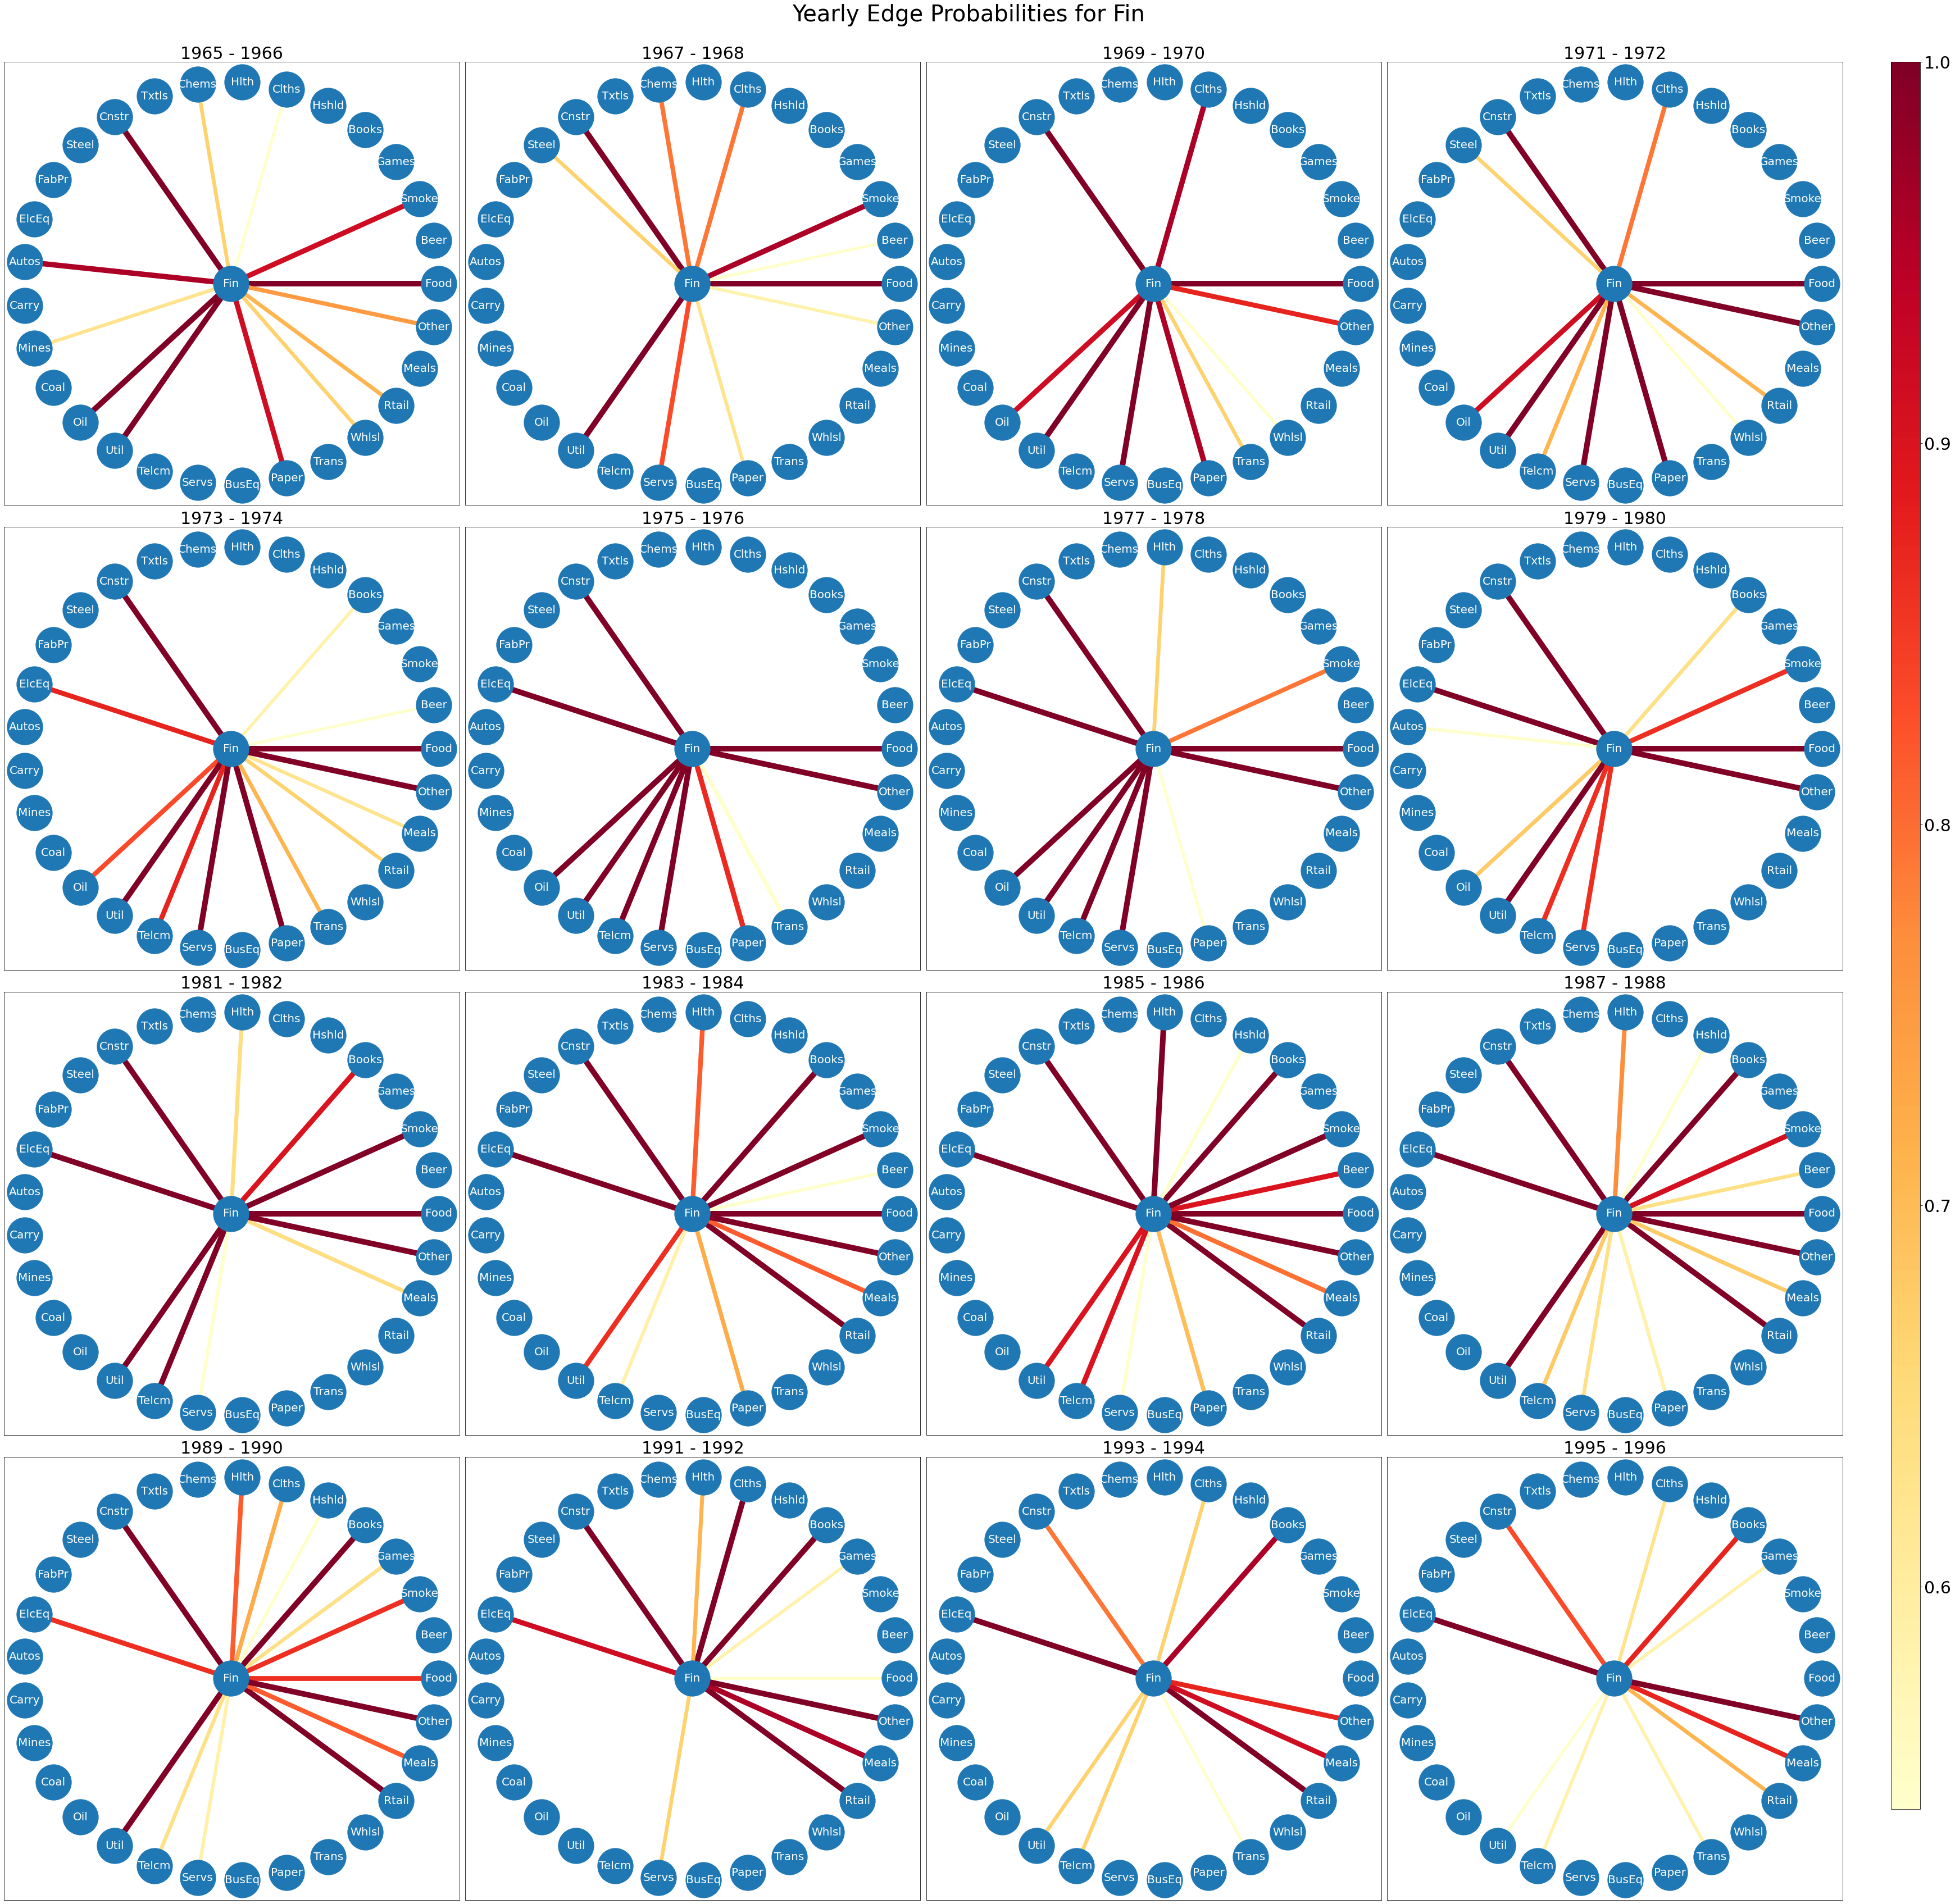

In [19]:
for i in [0, 2, 10, 17, 18, 28]:
    yearly_probabilities(pre_tpe_thres[1e-4][8:], 24, 0.5, i, labels)
#     yearly_diff_probabilities(pre_tpe_thres[1e-4][100:], 24, 0, i, labels)
#     degree(pre_tpe_thres[1e-4][100:], i, labels)

In [ ]:
debug

In [ ]:
def yearly_probabilities(precisions, labels):
    import math

    time_points, _, _ = precisions.shape
    n_years = np.floor(time_points / 12).astype(int)

    probs = {}
    
    for i in range(n_years):
        for j in range(12):
            try:
                probs[i] += (abs(precisions[(i*12) + j]) > 0).astype(int)
            except KeyError:
                probs[i] = (abs(precisions[(i*12) + j]) > 0).astype(int)
        probs[i] = probs[i] / 12
        
    fig, axes = plt.subplots(nrows=2, ncols=int(len(probs.keys()) / 2), figsize=(12 * int(len(probs.keys()) / 2), 12 * 2 ))
    fig.suptitle('Yearly Edge Probabilities', fontsize=40)
    
    for i in probs.keys():
#         pdb.set_trace()
        gr = nx.from_numpy_matrix(probs[i])
#         gr.add_nodes_from(range(len(labels)))
#         gr.add_weighted_edges_from(probs[i])
        pos = nx.spring_layout(gr)
        nx.draw_networkx_nodes(gr, pos, ax=axes.flat[i], node_size=4000)
        edges = nx.draw_networkx_edges(gr, pos, ax=axes.flat[i])
        nx.draw_networkx_labels(gr, pos, ax=axes.flat[i], labels=labels, font_size=20, font_color='white')

#         nx.draw(gr, pos, ax=axes[i], node_size=1500, font_color='white', labels=labels, with_labels=True, cmap=cmap, node_color=prob)
    #     pdb.set_trace()
        axis = plt.gca()
#         fig.subplots_adjust(right=0.8)
#         cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.tight_layout()
    fig.subplots_adjust(top=0.95, right=0.95)
    cbar_ax = fig.add_axes([0.975, 0.05, 0.015, 0.9])
    cbar = fig.colorbar(edges, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=30)
    
#     plt.axis("off")
    plt.show()

In [ ]:
yearly_probabilities(pre_tpe_thres[1e-4], labels)

In [ ]:
total_diff = abs(prob_diff[1])

for i in range(2, n_years):
    total_diff += abs(prob_diff[i])

In [ ]:
change = []
for i in range(len(labels_)):
    if total_diff[i] == 0:
        change.append(labels_[i])
        
print(change)

In [ ]:
factor = {}

for i in range(n_years):
    g = (prob[i] > 0.8)
    factor[i] = []
    for j in range(len(labels_)):
        if g[j] == 1:
            factor[i].append(labels_[j])
            
print(factor)

for i in range(1, n_years):
    curr = set(factor[i])
    prev = set(factor[i-1])
    print(curr.intersection(prev))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
G = nx.from_numpy_matrix(np.array(pre_tpe_thres[1e-4][50])) 
partition = nx.algorithms.community.greedy_modularity_communities(G)
print(list(partition))
# G = nx.relabel_nodes(G, labels)
cmap = cm.get_cmap('viridis', length(partition) + 1)
nx.draw_circular(G, node_size=1500, font_color='white', labels=labels, with_labels=True, cmap=cmap, node_color=list(partition.values())) 

# nx.draw_spring(G, node_size=1500, font_color='white', labels=labels, with_labels=True) 
# print(list(nx.enumerate_all_cliques(G)))

In [ ]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
G = nx.from_numpy_matrix(np.array(pre_tpe_thres[1e-4][51])) 
# partition = community_louvain.best_partition(G)
partition = nx.algorithms.community.greedy_modularity_communities(G)
print(partition)
# pos = nx.spring_layout(G)
# color the nodes according to their partition
fig, ax = plt.subplots(figsize=(20, 20))
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_circular(G, node_size=1500, font_color='white', labels=labels, with_labels=True, cmap=cmap, node_color=list(partition.values())) 
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
G = nx.from_numpy_matrix(np.array(pre_tpe_thres[1e-4][51])) 
# G = nx.relabel_nodes(G, labels)
nx.draw_circular(G, node_size=1500, font_color='white', labels=labels, with_labels=True) 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
G = nx.from_numpy_matrix(np.array(pre_tpe_thres[1e-4][52])) 
# G = nx.relabel_nodes(G, labels)
nx.draw_circular(G, node_size=1500, font_color='white', labels=labels, with_labels=True) 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
G = nx.from_numpy_matrix(np.array(pre_tpe_thres[1e-4][53])) 
# G = nx.relabel_nodes(G, labels)
nx.draw_circular(G, node_size=1500, font_color='white', labels=labels, with_labels=True) 

In [ ]:
show_graph_with_labels(abs(pre_tpe_thres[1e-4][50][0]) > 0, pos, 0, labels)

In [ ]:
show_graph_with_labels(abs(pre_tpe_thres[1e-4][51][0]) > 0, pos, 0, labels)

In [ ]:
show_graph_with_labels(abs(pre_tpe_thres[1e-4][52][0]) > 0, pos, 0, labels)

In [ ]:
show_graph_with_labels(abs(pre_tpe_thres[1e-4][53][0]) > 0, pos, 0, labels)